### Session 2: Hands-On - Fashion-MNIST Classifier (Keras)

In this session, you'll build a simple CNN to recognize clothing items from the Fashion-MNIST dataset.

Learning goals:
- Load and inspect Fashion-MNIST data from Keras datasets
- Normalize images and prepare train/validation/test splits
- Build a concise CNN with Keras Sequential API
- Train with EarlyStopping and monitor validation accuracy
- Evaluate on the test set and visualize misclassifications


In [ ]:
# Install dependencies (if needed)
!pip -q install tensorflow numpy matplotlib scikit-learn opencv-python-headless



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\varsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Setup
This notebook is Colab-ready. The required libraries come with Colab. If running locally, ensure you have TensorFlow (with Keras), NumPy, and Matplotlib installed.

We will:
- Import libraries
- Set a random seed for reproducibility
- Define a simple utility to map class indices to names


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Class names
CLASS_NAMES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]


### 1) Load Fashion-MNIST dataset
Keras provides Fashion-MNIST out of the box. It includes 60k training and 10k test grayscale images of size 28x28.

We will split the original train into train/validation to monitor validation accuracy during training.


### Quick look at samples
Before normalization, let's visualize a few training images with their labels to understand the data.


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Keep a validation split from training data
from sklearn.model_selection import train_test_split
#TODO: Create x_train, x_valid, y_train, y_valid from training data with test_size=0.1 and random_state=SEED


# x_train.shape, x_valid.shape, x_test.shape


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((54000, 28, 28), (6000, 28, 28), (10000, 28, 28))

##
This cell displays the first 50 training images in a 5x10 grid with class names. It works whether images are raw (0–255) or normalized (0–1), and squeezes the channel if present.


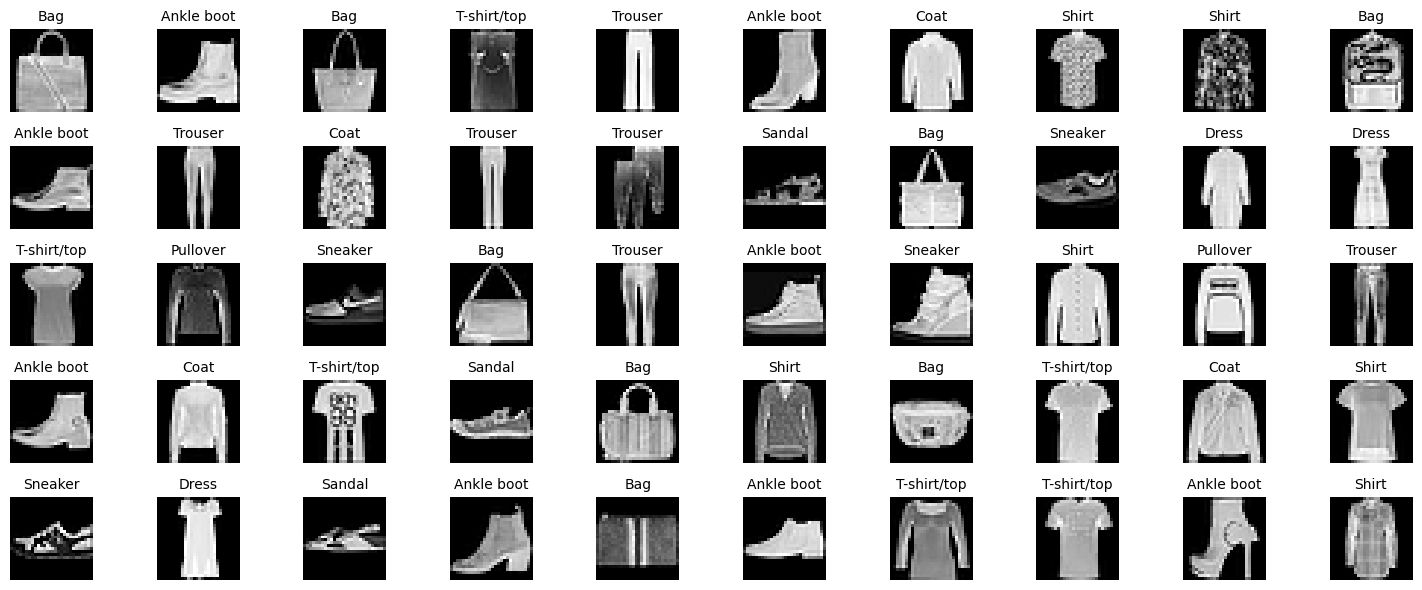

In [20]:
plt.figure(figsize=(15, 6))
plotnumber = 1

for i in range(50):
    if plotnumber <= 50:
        ax = plt.subplot(5, 10, plotnumber)
        img = x_train[i]
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)
        vmax = 255.0 if img.max() > 1.5 else 1.0
        plt.imshow(img, cmap='gray', vmin=0.0, vmax=vmax, interpolation='nearest')
        plt.axis('off')
        plt.title(CLASS_NAMES[y_train[i]], fontdict={'fontsize': 10, 'color': 'black'})
        plotnumber += 1

plt.tight_layout()
plt.show()


### 2) Normalize and reshape
- Scale pixel values from [0, 255] to [0, 1].
- Add channel dimension (1) because Conv2D expects (H, W, C).


In [ ]:
# Normalize to [0,1] and add channel dim
x_train = (x_train.astype('float32') / 255.0)[..., np.newaxis]
#TODO: Normalize x_valid and x_test similarly

x_train.shape, x_valid.shape, x_test.shape


((54000, 28, 28, 1), (6000, 28, 28, 1), (10000, 28, 28, 1))

### 3) Build a simple CNN (Keras Sequential)
We'll use two convolutional layers followed by a dense classifier with dropout.

Model summary will confirm layer shapes and parameter counts.


In [8]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.summary()


C:\Users\varsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,466 (3.86 MB)

 Trainable params: 1,011,466 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

### 4) Compile and train (5 epochs) with EarlyStopping
- Optimizer: Adam
- Loss: SparseCategoricalCrossentropy (labels are integers 0-9)
- Metrics: Accuracy
- EarlyStopping: monitor validation accuracy, restore best weights


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#TODO:Set early stopping patience for best val_accuracy
early_stop = EarlyStopping(monitor='val_accuracy', patience=?, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=5,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

print(f"Best val accuracy: {max(history.history['val_accuracy']):.4f}")


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.8176 - loss: 0.5073 - val_accuracy: 0.8868 - val_loss: 0.3167
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8818 - loss: 0.3270 - val_accuracy: 0.9018 - val_loss: 0.2678
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8991 - loss: 0.2759 - val_accuracy: 0.9128 - val_loss: 0.2419
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9099 - loss: 0.2451 - val_accuracy: 0.9197 - val_loss: 0.2243
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9190 - loss: 0.2178 - val_accuracy: 0.9235 - val_loss: 0.2091
Best val accuracy: 0.9235


### 5) Evaluate on test set
We'll compute accuracy and print a quick classification report-like summary (confusion matrix optional to keep things simple).


In [10]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# Predictions for misclassification analysis
y_pred_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)


Test accuracy: 0.9115


### 6) Visualize misclassifications (keep it simple)
We'll show a small grid of misclassified examples with predicted vs true labels.


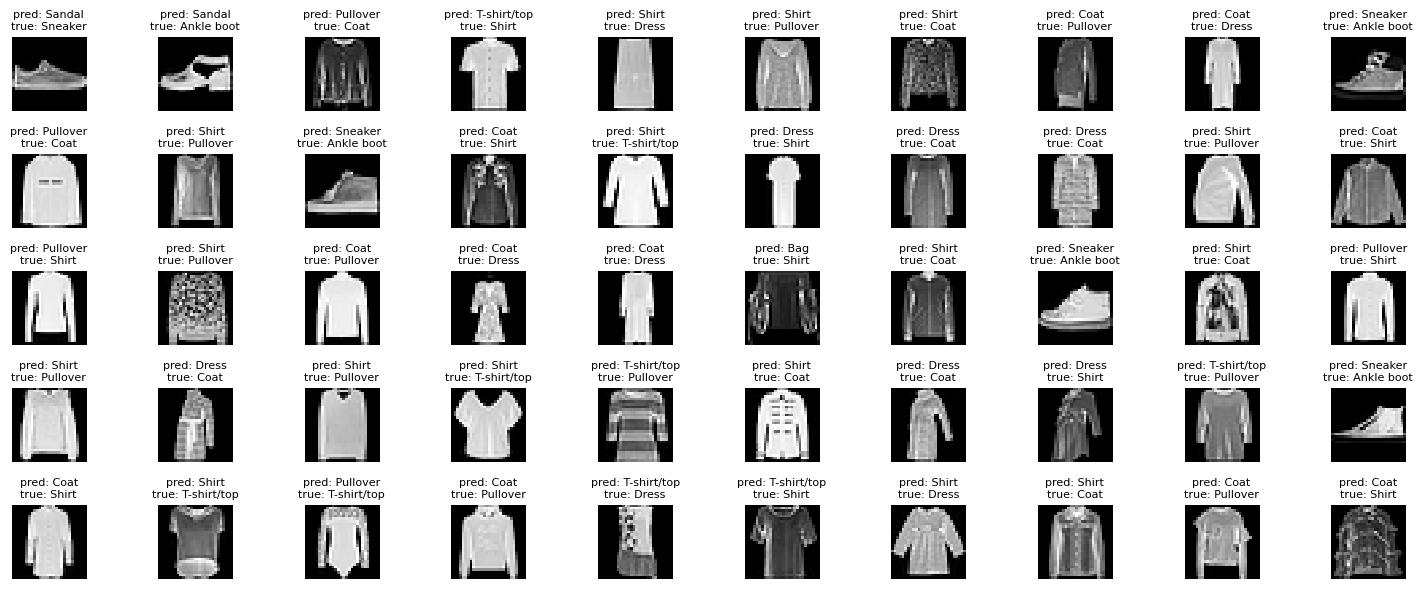

In [21]:
# 5x10 grid of misclassified examples
mis_idx = np.where(y_pred != y_test)[0]
count = min(50, len(mis_idx))
sel = mis_idx[:count]

plt.figure(figsize=(15, 6))
plotnumber = 1
for idx in sel:
    if plotnumber <= 50:
        ax = plt.subplot(5, 10, plotnumber)
        img = x_test[idx]
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)
        vmax = 255.0 if img.max() > 1.5 else 1.0
        plt.imshow(img, cmap='gray', vmin=0.0, vmax=vmax, interpolation='nearest')
        plt.axis('off')
        plt.title(f"pred: {CLASS_NAMES[y_pred[idx]]}\ntrue: {CLASS_NAMES[y_test[idx]]}", fontsize=8)
        plotnumber += 1
plt.tight_layout()
plt.show()


### 7) Visualize what happens inside convolution layers
We’ll pick one test image and visualize the intermediate feature maps produced by each Conv2D layer. This helps build intuition for what the network is detecting at each depth (edges, textures, parts, etc.).


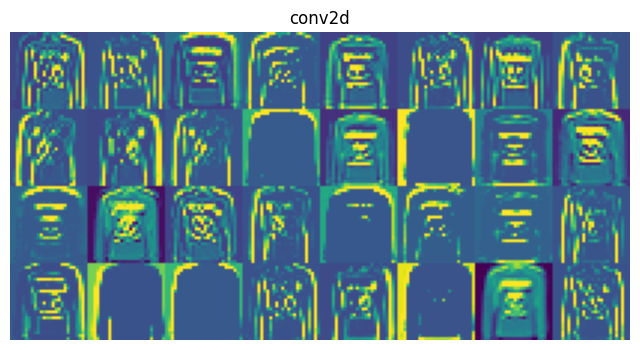

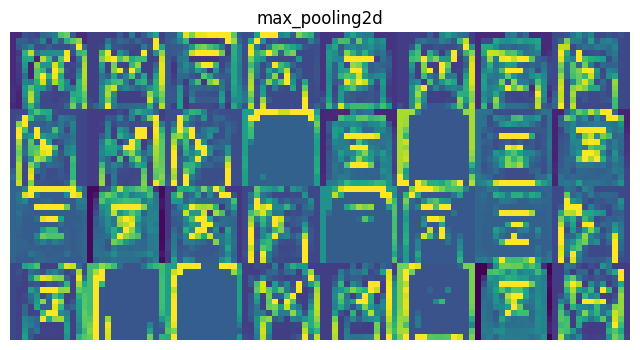

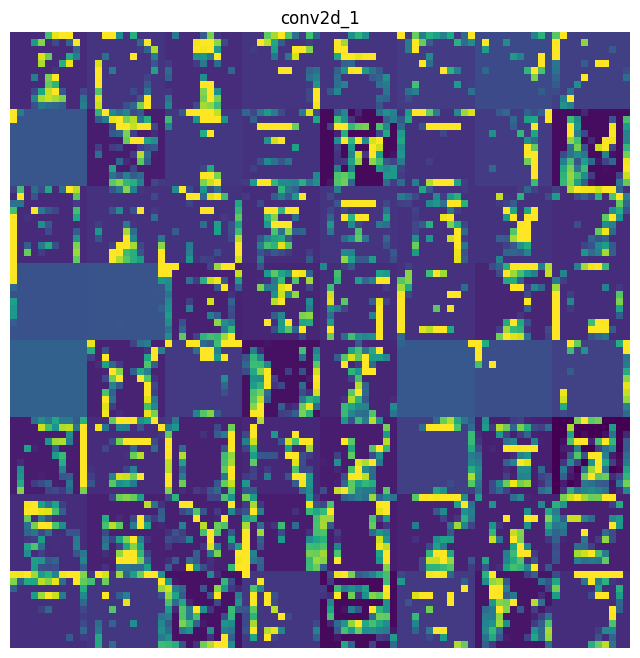

In [31]:
# Activation grids per layer (adapted)
# Pick a test image and ensure batch dimension
idx = np.random.randint(0, len(x_test))
img_batch = x_test[idx:idx+1]

# Warm-up call to define inputs in Sequential
_ = model.predict(img_batch, verbose=0)

# Select spatial layers explicitly to ensure non-empty outputs
spatial_layers = [l for l in model.layers if isinstance(l, (Conv2D, MaxPooling2D))]
layer_outputs = [l.output for l in spatial_layers]
layer_names = [l.name for l in spatial_layers]

# Build activation model using first layer's input to avoid undefined model.input
activation_model = tf.keras.models.Model(inputs=model.layers[0].input, outputs=layer_outputs)
activations = activation_model.predict(img_batch, verbose=0)

images_per_row = 8  # 16 can be very small; use 8 for readability
for layer_name, layer_activation in zip(layer_names, activations):
    # Expect shape: (1, h, w, channels). Skip non-4D
    if layer_activation.ndim != 4:
        continue
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = max(1, int(np.ceil(n_features / images_per_row)))
    grid_h = size * n_cols
    grid_w = size * images_per_row
    display_grid = np.zeros((grid_h, grid_w), dtype=np.float32)
    for col in range(n_cols):
        for row in range(images_per_row):
            ch_idx = col * images_per_row + row
            if ch_idx >= n_features:
                continue
            channel_image = layer_activation[0, :, :, ch_idx]
            # Normalize per-channel for visualization
            mean = channel_image.mean()
            std = channel_image.std() if channel_image.std() > 1e-6 else 1.0
            channel_image = (channel_image - mean) / std
            channel_image = (channel_image * 64.0) + 128.0
            channel_image = np.clip(channel_image, 0, 255)
            y0 = col * size
            x0 = row * size
            display_grid[y0:y0+size, x0:x0+size] = channel_image
    scale = 1.0 / max(1, size)
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid.astype('uint8'), aspect='auto', cmap='viridis')
    plt.axis('off')
    plt.show()
